In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import itertools
from collections import OrderedDict
from functools import partial

from sklearn.datasets import load_svmlight_file, make_circles


from links import LinksClassifier
from logit import LogisticRegressionPairwise, LogisticRegression


from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook as tqdm

from new_experiment_runner.cacher import CSVCacher

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
semi = pd.read_csv('data/semi_tnc.csv')

In [4]:
semi.head()

,cv_split,percent_unlabeled,percent_links,dataset,estimator,cv_random_state,percent_labels,test_score,train_score
0,0.0,0.2,0.2,diabetes_scale,LinksClassifier-labels-links,42.0,0.2,0.714286,0.754098
1,1.0,0.2,0.2,diabetes_scale,LinksClassifier-labels-links,42.0,0.2,0.727273,0.754098
2,2.0,0.2,0.2,diabetes_scale,LinksClassifier-labels-links,42.0,0.2,0.720779,0.737705
3,3.0,0.2,0.2,diabetes_scale,LinksClassifier-labels-links,42.0,0.2,0.714286,0.745902
4,4.0,0.2,0.2,diabetes_scale,LinksClassifier-labels-links,42.0,0.2,0.655844,0.696721


In [8]:
grouped = pd.groupby(semi, by=['dataset', 'estimator']).agg({'test_score': [np.mean, np.std], 'train_score':[np.mean, np.std]}).unstack(level=-1)

In [11]:
grouped.columns

MultiIndex(levels=[[u'test_score', u'train_score'], [u'mean', u'std'], [u'LinksClassifier-labels-links', u'LinksClassifier-labels-links-unlabeled']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 0, 0, 1, 1], [0, 1, 0, 1, 0, 1, 0, 1]],
           names=[None, None, u'estimator'])

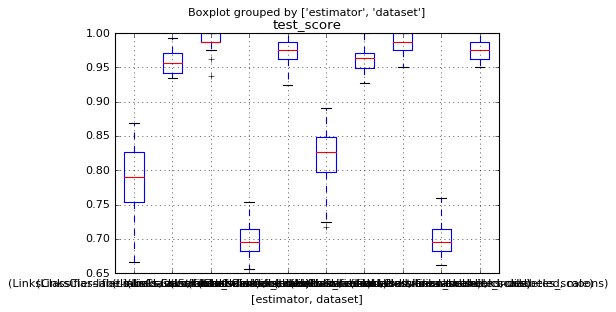

In [15]:
semi.boxplot(column='test_score', by=['estimator', 'dataset'])

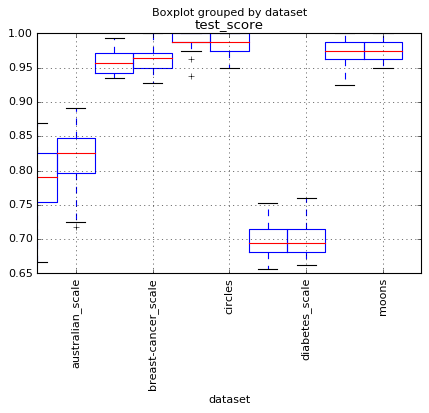

In [36]:
fig, ax = plt.subplots()
semi
for i, est in enumerate(semi.estimator.unique()):
    df = semi.ix[semi['estimator'] == est]
    if i == 0:
        offset = -0.25
        c = 'g'
    elif i == 1:
        offset = 0.25
        c = 'r'
    df.boxplot(column='test_score', by='dataset', ax=ax, rot=90,positions=np.arange(2, 7)+ offset)

In [57]:

train_data = []
test_data = []
datasets = []
for (ds_name, estimator), df in pd.groupby(semi, by=['dataset', 'estimator']):
    train_data.append(df['train_score'].values)
    test_data.append(df['test_score'].values)
    
    #df['train_score'].boxplot(ax=ax)

In [125]:
from matplotlib.patches import Polygon
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = plt.boxplot(train_data, notch=0, sym='+', vert=1, whis=1.5)
bp2 = plt.boxplot(test_data, notch=0, sym='+', vert=1, whis=1.5, positions=np.arange(1, len(data)+1)+0.35)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

plt.setp(bp2['boxes'], color='black')
plt.setp(bp2['whiskers'], color='black')
plt.setp(bp2['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of training with and withoug unlabeled data')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Accuracy')

# Now fill the boxes with desired colors
boxColors = ['darkkhaki', 'royalblue']
numBoxes = len(data)
medians_train = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians_train[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
#     plt.plot([np.average(med.get_xdata())], [np.average(train_data[i])],
#              color='w', marker='*', markeredgecolor='k')
    
boxColors = ['darkkhaki', 'royalblue']
numBoxes = len(test_data)
medians_test = list(range(numBoxes))
for i in range(numBoxes):
    box = bp2['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp2['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians_test[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
#     plt.plot([np.average(med.get_xdata())], [np.average(test_data[i])],
#              color='w', marker='*', markeredgecolor='k')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
top = 1.1
bottom = 0.6
ax1.set_ylim(bottom, top)
positions = np.sort(np.concatenate([np.arange(1, len(train_data)+1), np.arange(1, len(test_data)+1)+0.35]))
positions = positions.reshape(-1, 2).mean(axis=1) 

ax1.set_xticks(positions)
xtickNames = plt.setp(ax1, xticklabels=np.repeat(semi.dataset.unique(), 2))
plt.setp(xtickNames, rotation=45, fontsize=8)



# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians_train]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])
    ax1.text(pos[tick], top - (top*0.02), 'train',
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])
    
pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians_test]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick]+0.35, top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])
    ax1.text(pos[tick]+0.35, top - (top*0.02), 'test',
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])


import matplotlib.patches as mpatches
patch1 = mpatches.Patch(color=boxColors[0], label='without unlabeled')
patch2 = mpatches.Patch(color=boxColors[1], label='with unlabeled')
plt.legend(handles=[patch1, patch2], loc=4, prop={'size':10})


plt.show()

In [124]:
%matplotlib tk

In [91]:
np.repeat(['train', 'test'], len(train_data))

array(['train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'test', 'test', 'test', 'test', 'test',
       'test', 'test', 'test', 'test', 'test'], 
      dtype='|S5')

array(['train', 'test', 'train', 'test', 'train', 'test', 'train', 'test',
       'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test',
       'train', 'test', 'train', 'test'], 
      dtype='|S5')